In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def ucitaj_podatke(putanja):
    columns=['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'Copyist']
    df=pd.read_csv(putanja)
    df.columns=columns
    return df

In [2]:
df_trening=ucitaj_podatke('avila/avila-tr.txt')
df_test=ucitaj_podatke('avila/avila-ts.txt')

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
def rad_sa_autlajerima(df) :
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    q1 = df[numeric_cols].quantile(0.25)
    q3 = df[numeric_cols].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_no_outliers = df[~((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)).any(axis=1)]

    num_outliers = len(df) - len(df_no_outliers)

    outliers_replaced = df.copy()
    for col in numeric_cols:
        lower_bound = outliers_replaced[col].quantile(0.01)
        upper_bound = outliers_replaced[col].quantile(0.99)
        outliers_replaced[col] = np.where(outliers_replaced[col] < lower_bound, lower_bound, outliers_replaced[col])
        outliers_replaced[col] = np.where(outliers_replaced[col] > upper_bound, upper_bound, outliers_replaced[col])
    return outliers_replaced, df_no_outliers, num_outliers

In [5]:
odsecanje, bez_autlajera, broj=rad_sa_autlajerima(pd.concat([df_trening, df_test])) #nisu nam potrebni trening i test skup

In [6]:
from sklearn.decomposition import PCA

In [7]:
def x_pca(df):
    X=df.iloc[:, :-1].values
    y=df.iloc[:, -1].values
    pca=PCA(n_components=2)
    X_pca=pca.fit_transform(X)
    return X_pca, X

In [8]:
def KMeans_autlajer(X_pca, X, i): #osetljiv je na autlajere
    
    kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++')
    kmeans.fit(X_pca)
    if i == 1 or i==12:
        s=None;
    else:
        s=silhouette_score(X, kmeans.labels_)
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans.labels_, cmap='rainbow', s=1)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', color='black')
    plt.xlabel('Prva glavna komponenta')
    plt.ylabel('Druga glavna komponenta')
    plt.title(f'KMeans klasterovanje nakon primene PCA redukcije atributa k={i}, s={s}')
    return kmeans.inertia_

In [9]:
X_pca, X=x_pca(odsecanje)

/home/lazar/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lazar/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lazar/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lazar/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lazar/.local/lib/python3.10/si

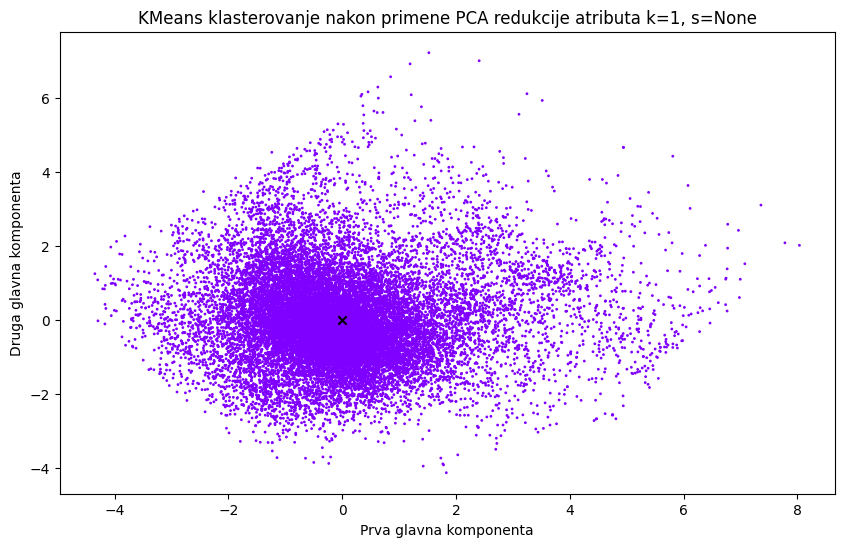

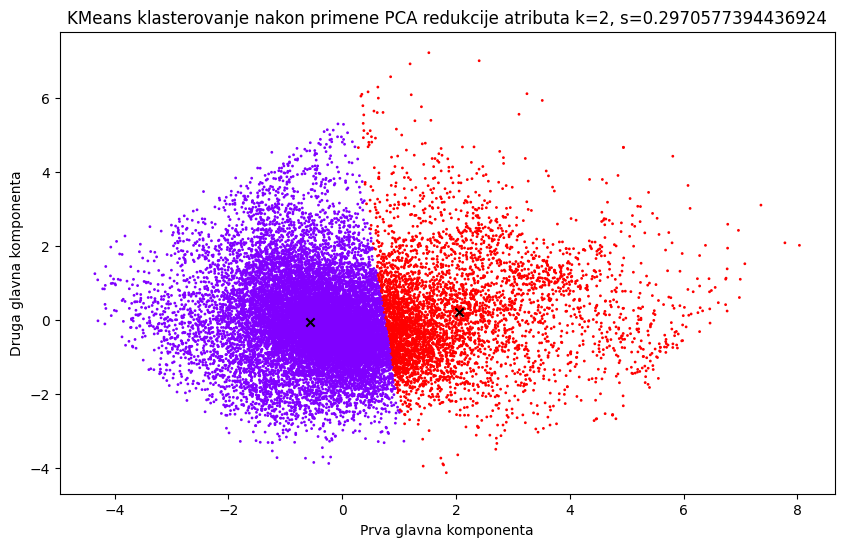

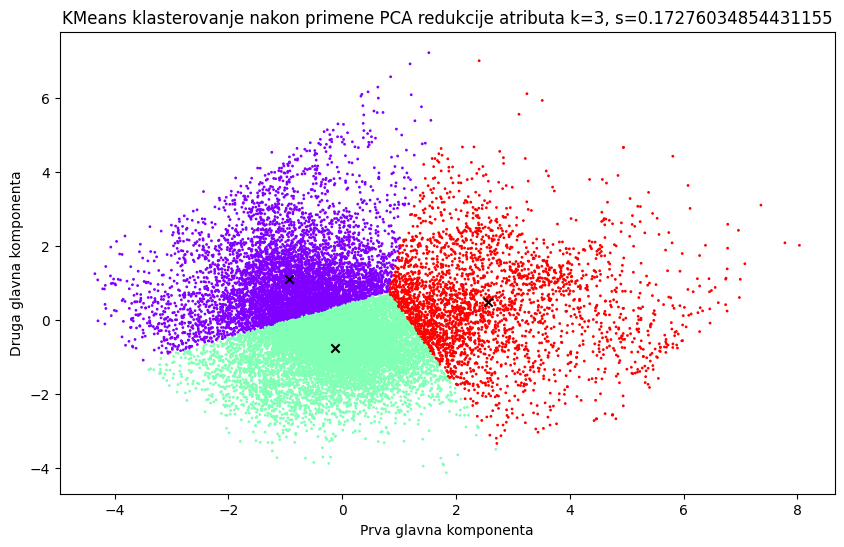

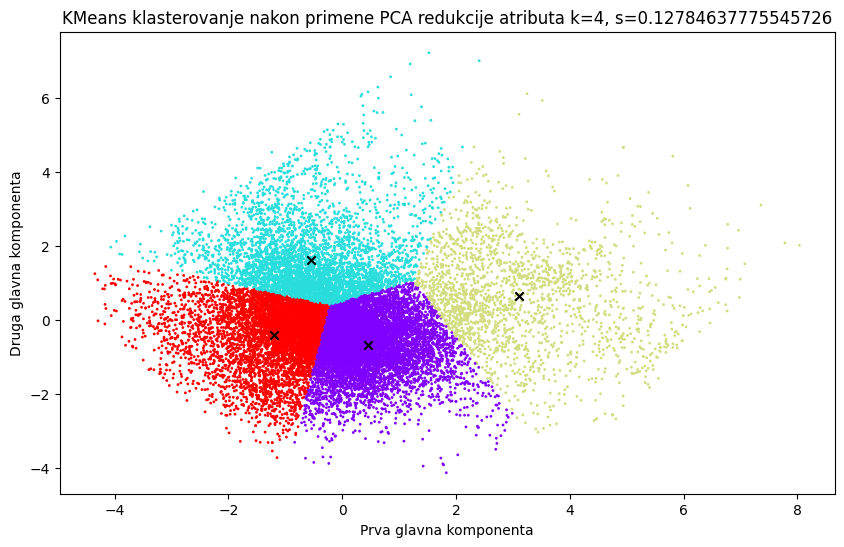

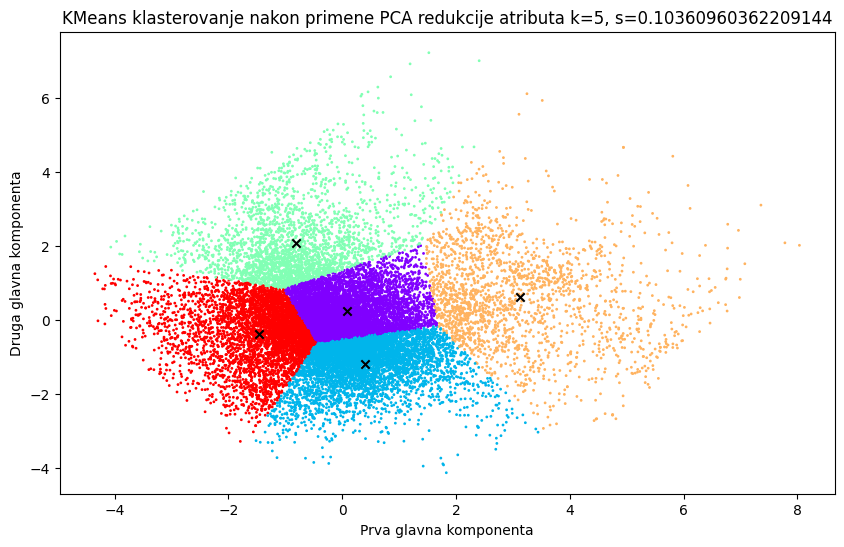

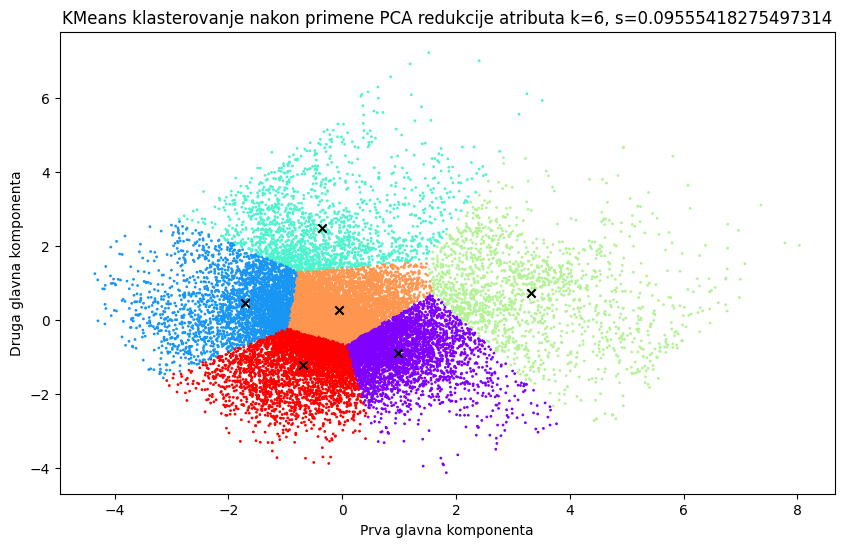

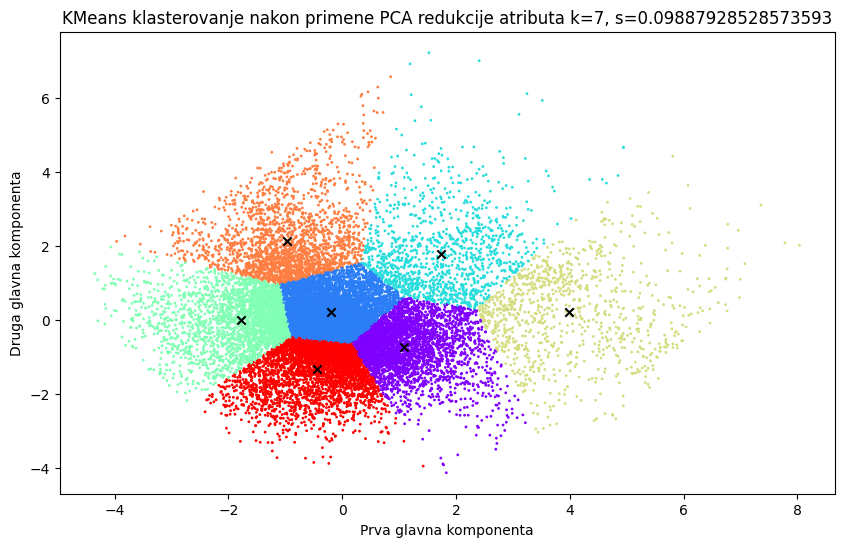

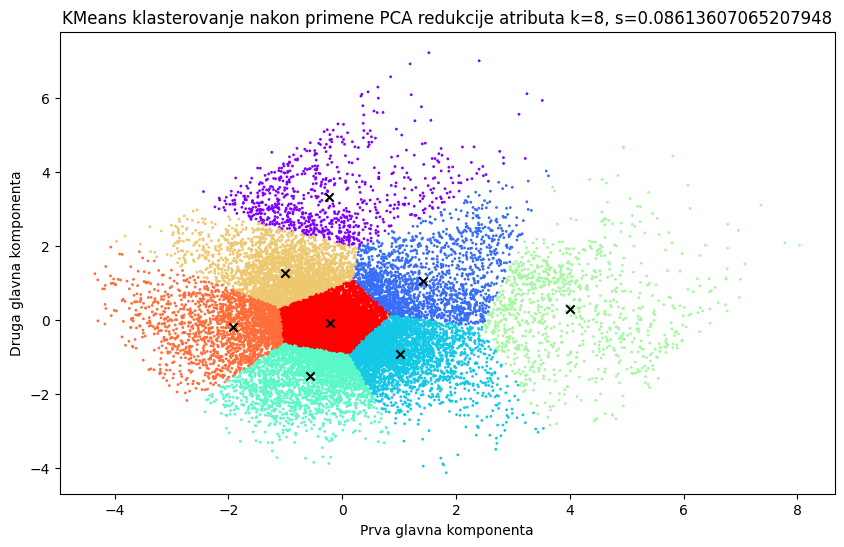

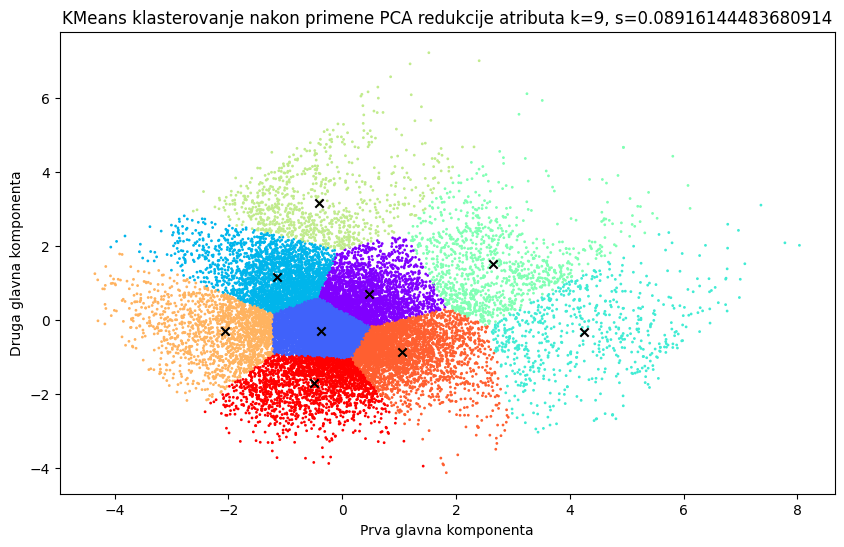

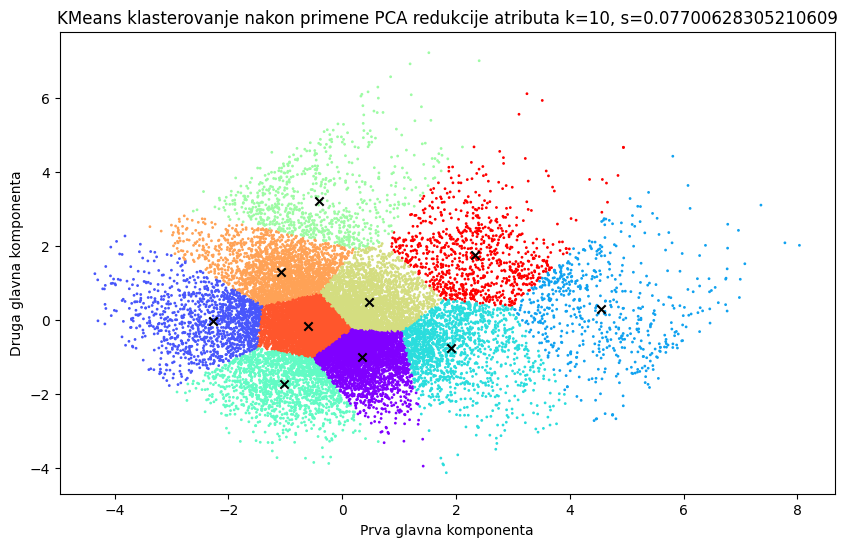

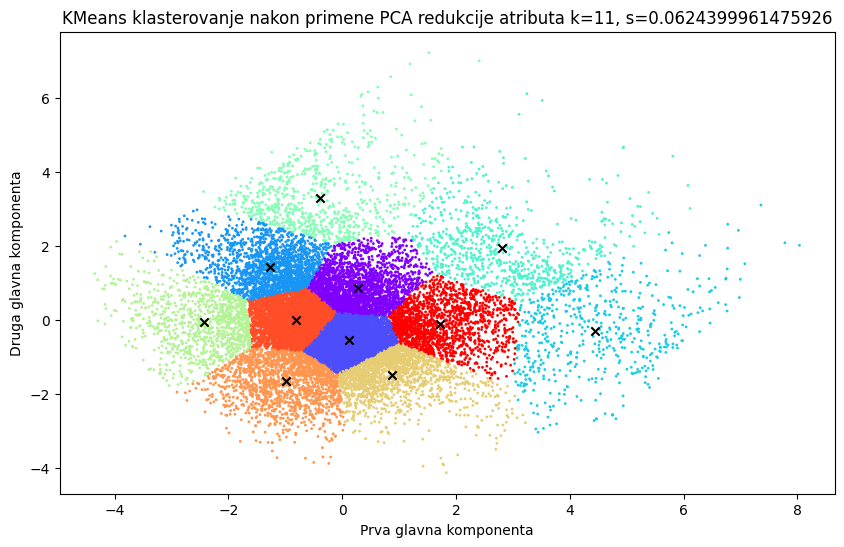

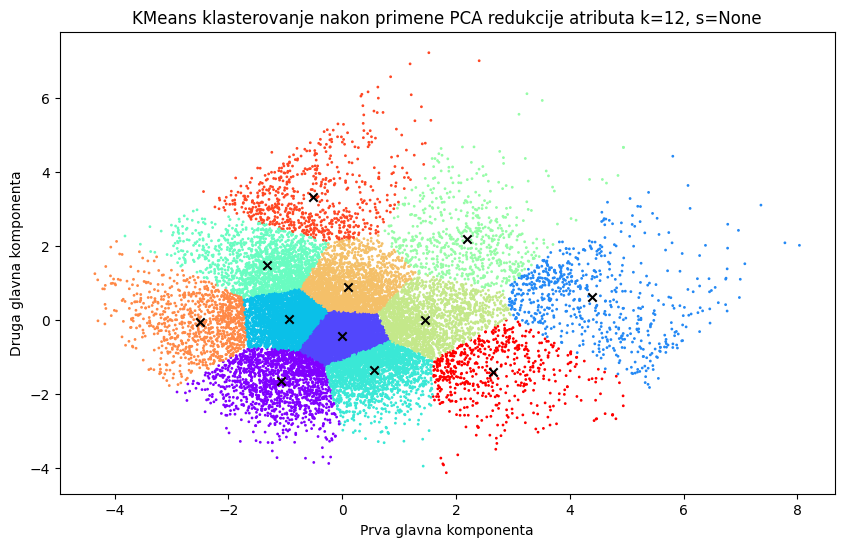

In [10]:
inertias=[]
for i in range(1, 13):
    inertias.append(KMeans_autlajer(X_pca, X, i))

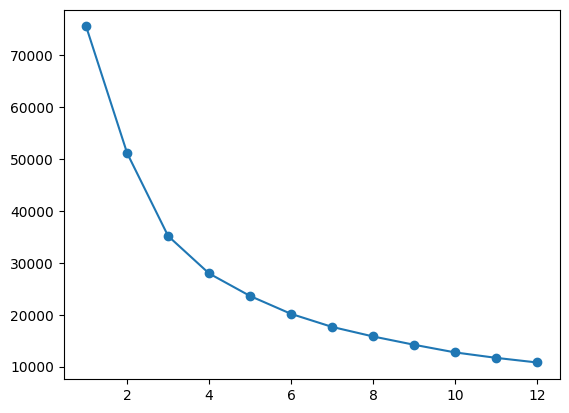

In [11]:
plt.plot(range(1, 13), inertias, marker='o')

In [13]:
from sklearn.cluster import DBSCAN

In [14]:
X_pca, X = x_pca(odsecanje)

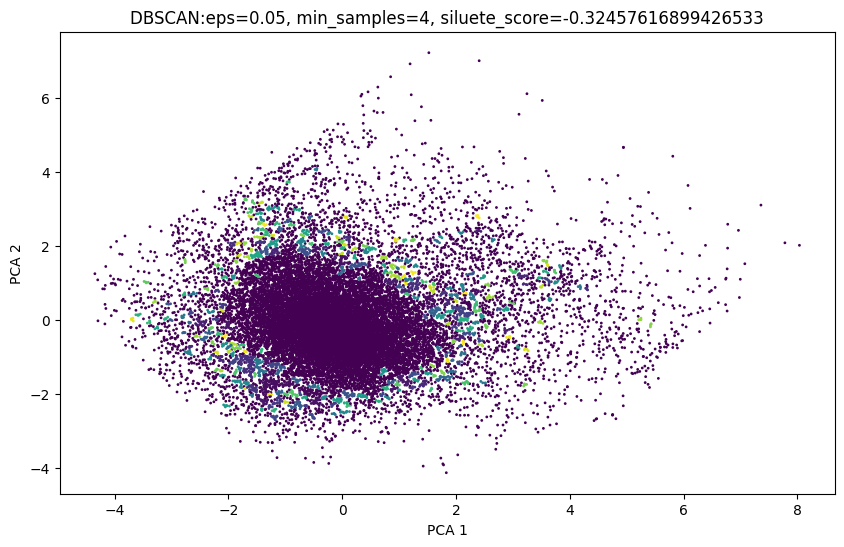

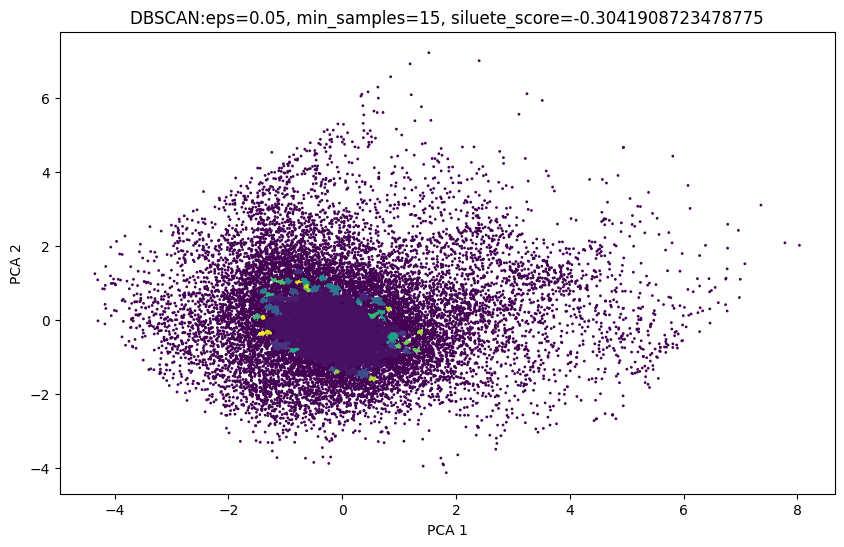

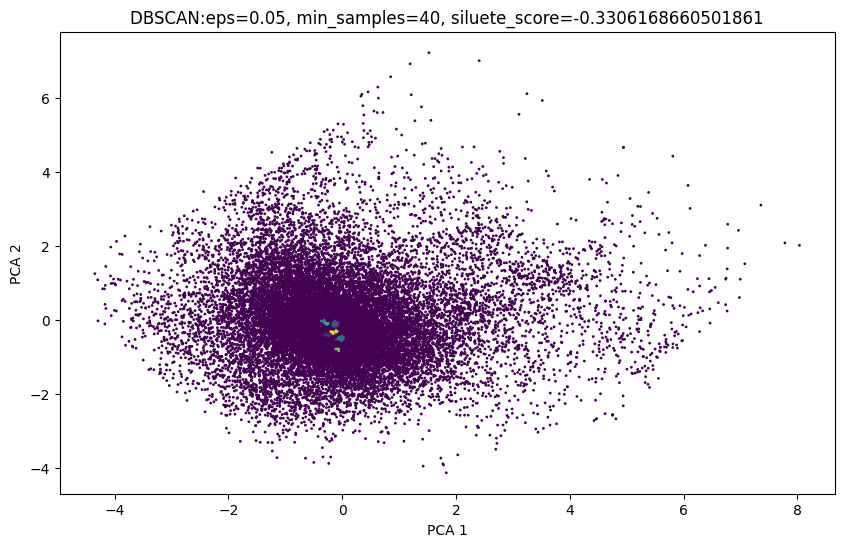

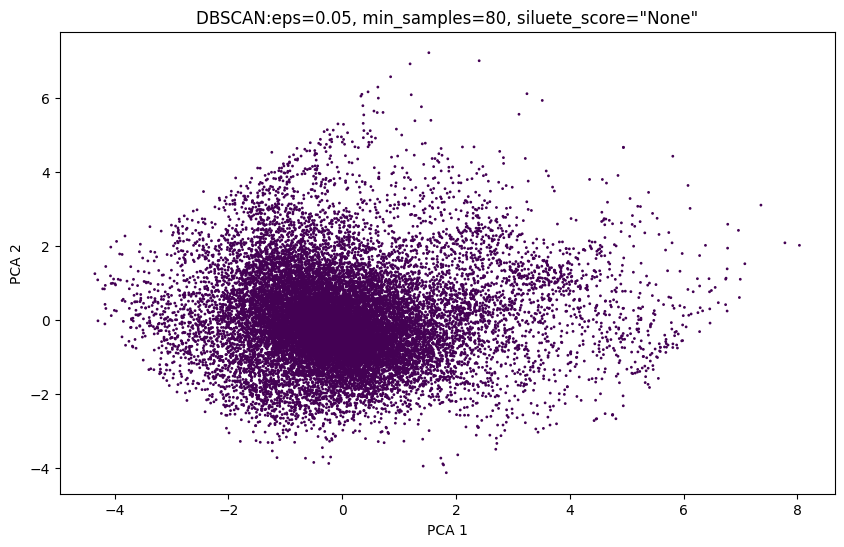

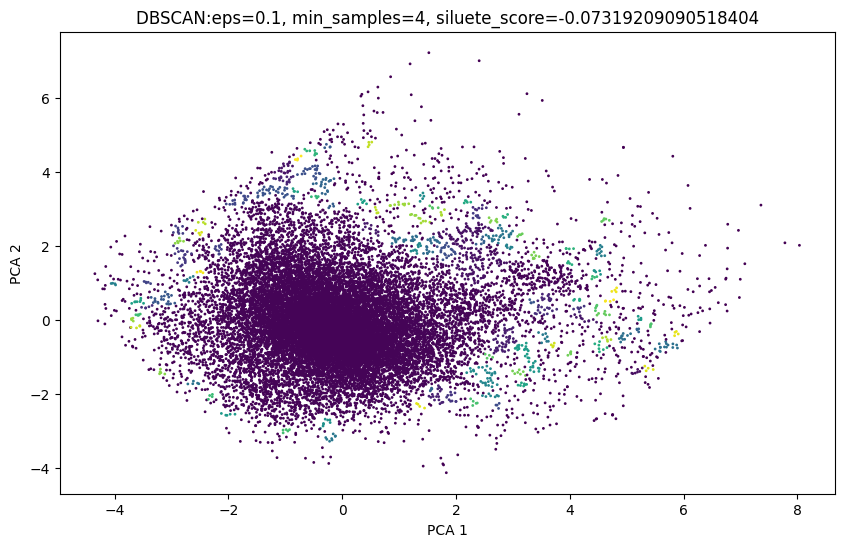

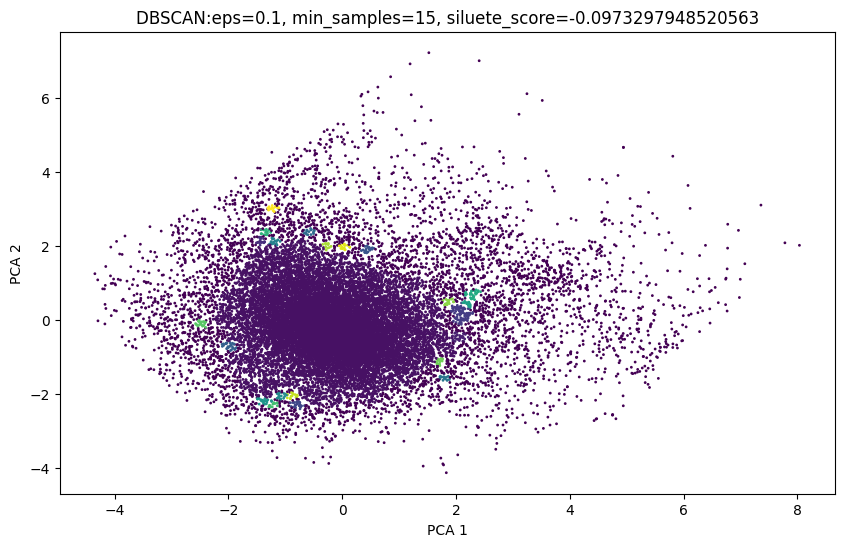

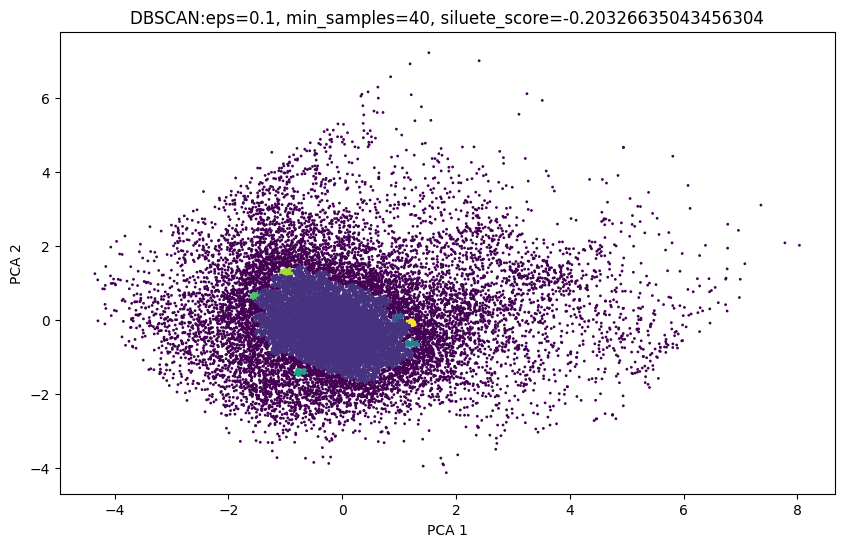

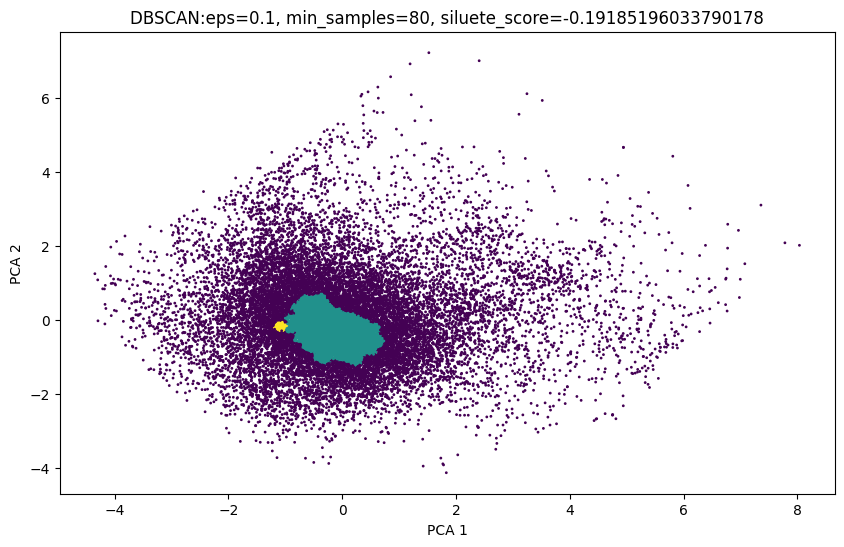

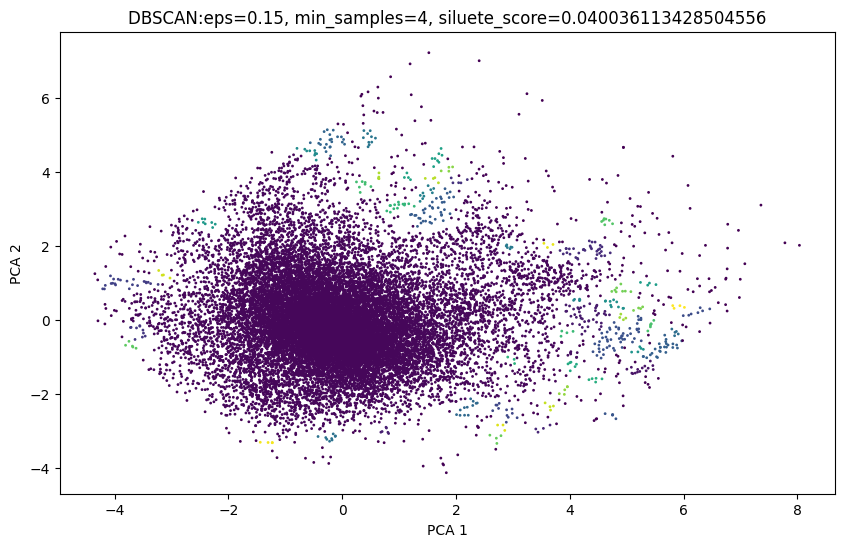

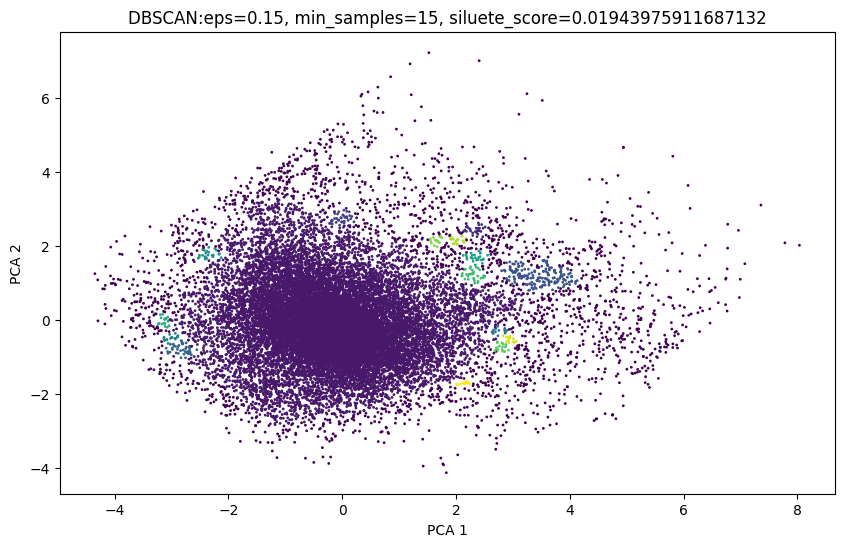

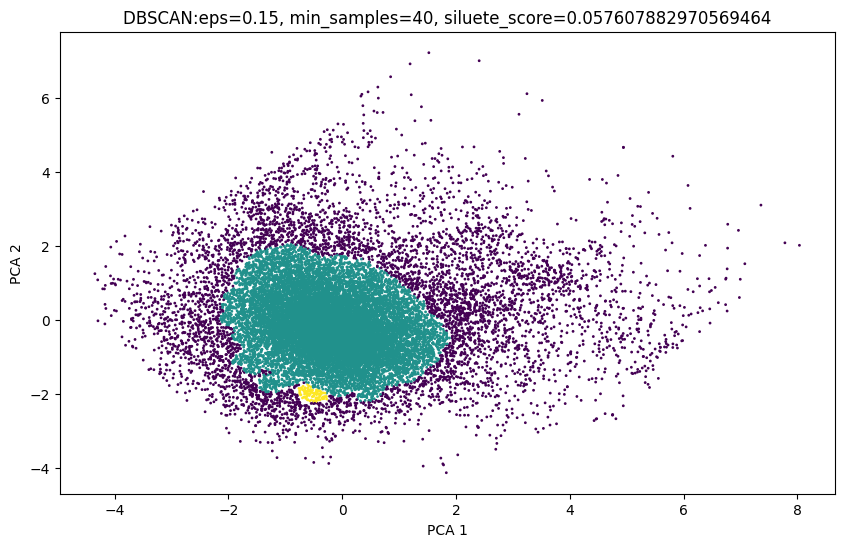

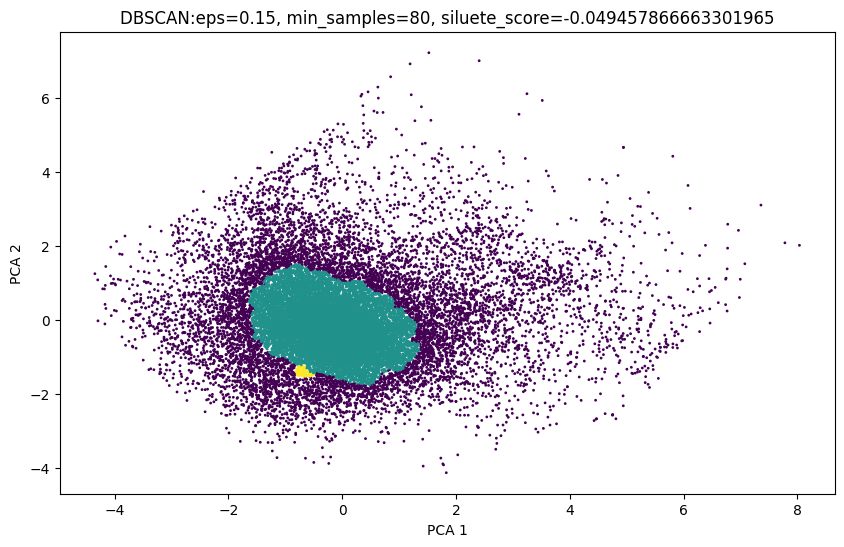

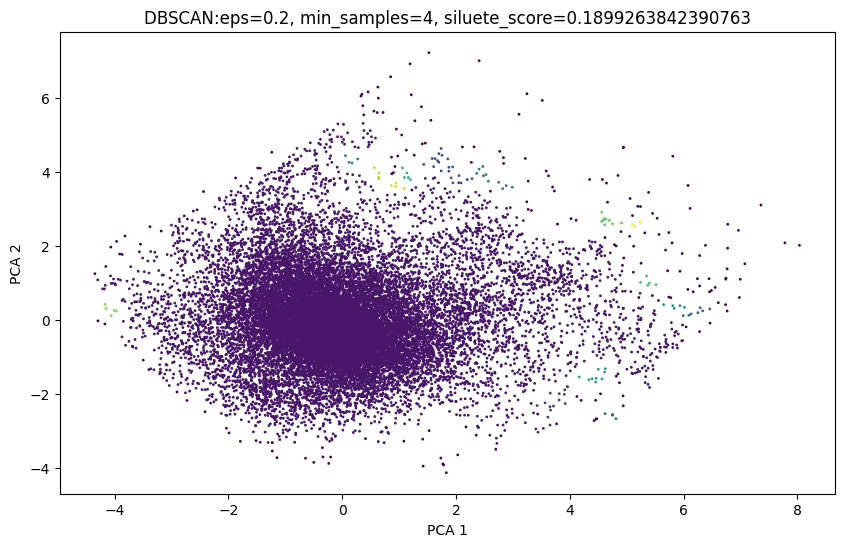

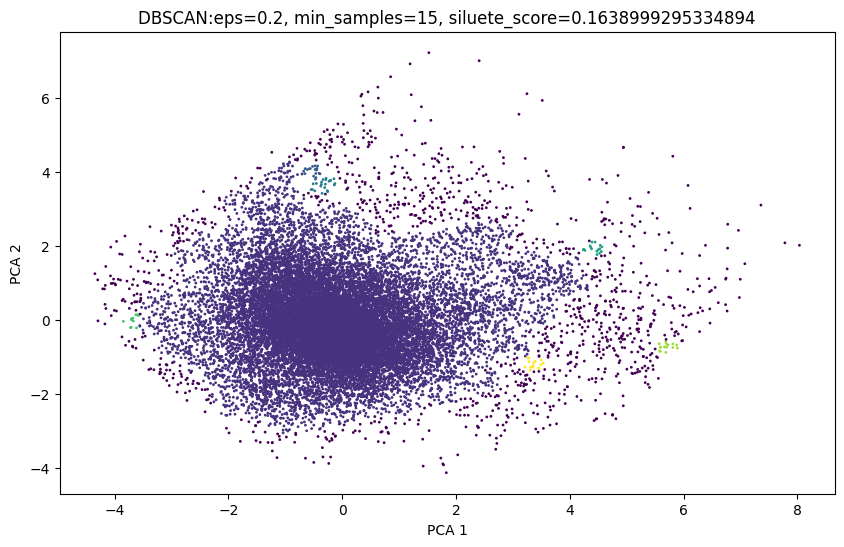

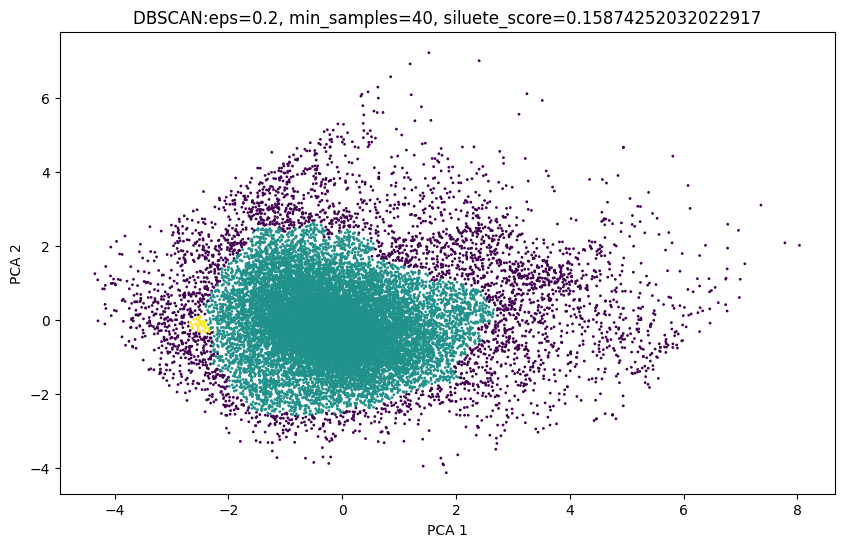

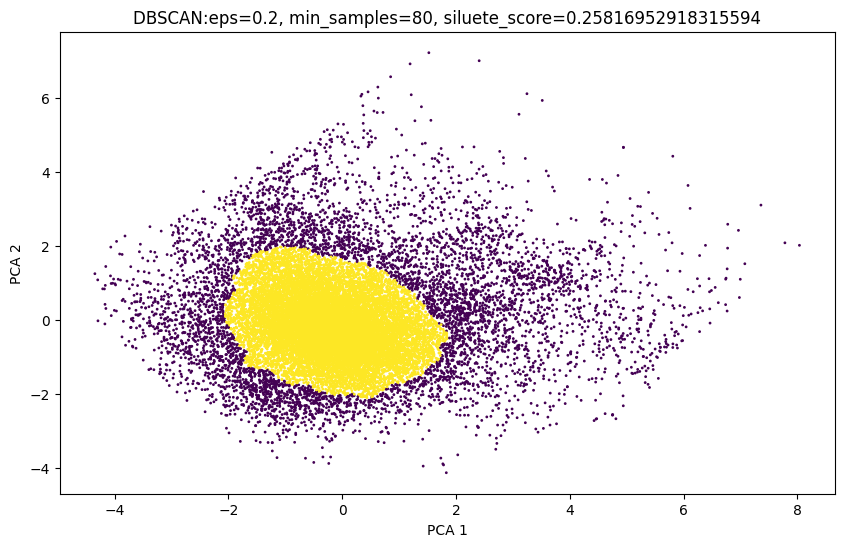

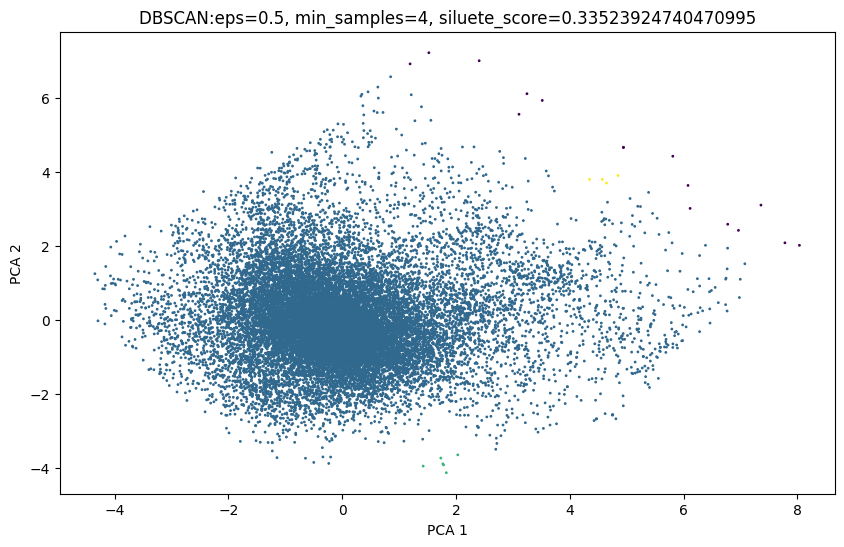

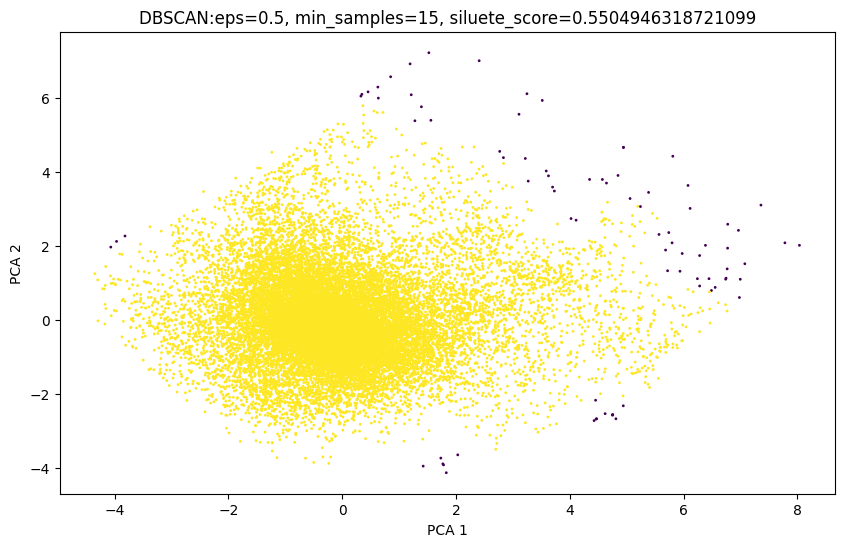

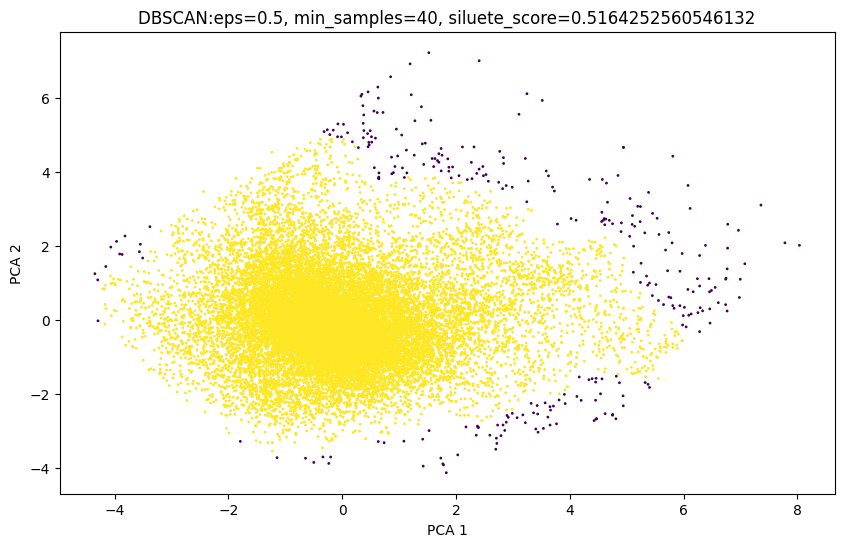

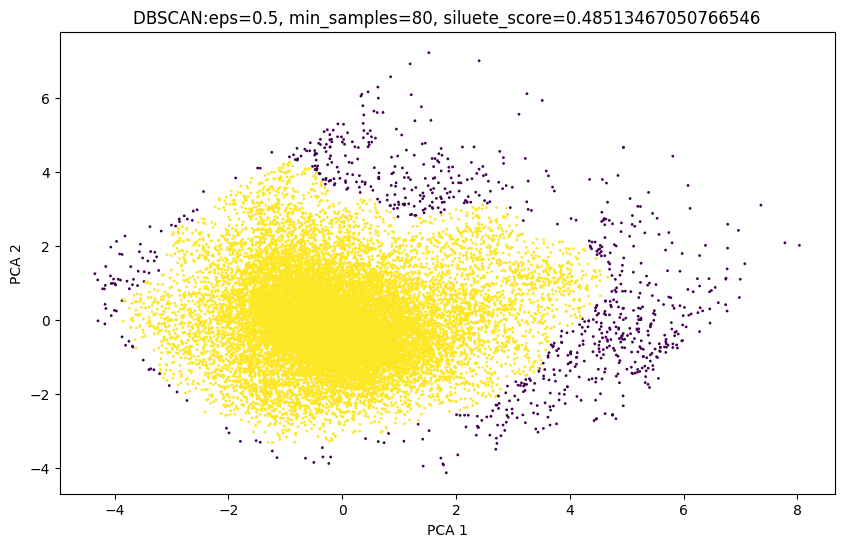

In [15]:
epss=[0.05, 0.1, 0.15, 0.2, 0.5]
min_sampless=[4, 15, 40, 80]
for eps in epss:
    for min_samples in min_sampless:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)
        labels = dbscan.fit_predict(X_pca)
        plt.figure(figsize=(10, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=1)
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        try:
            plt.title(f'DBSCAN:eps={eps}, min_samples={min_samples}, siluete_score={silhouette_score(X, dbscan.labels_)}')
        except:
            plt.title(f'DBSCAN:eps={eps}, min_samples={min_samples}, siluete_score="None"')
        plt.show()